In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

In [2]:
def extract_values(obj, key):
    """Recursively pull values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Return all matching values in an object."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    # if "Scan" in v:
                        # print(v)
                        # pdb.set_trace()
                    # if "Join" in v:
                        # print(obj)
                        # pdb.set_trace()
                    arr.append(v)

        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

def column_info(row):
    expr = row["FilterExprNorm"].values[0]
    print(expr)
    d = json.loads(expr)
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    num_cols = len(col_names)

In [201]:
FN = "combined-0J-2021-05-22.ss.csv"
INP_FIELD = "HashTagInput"

In [202]:
df = pd.read_csv(FN, sep="|")

In [203]:
df = df.rename(columns={"#Field:JobGUID":"jobid"})

In [204]:
# For some analysis, we may not want to drop duplicates here.
#df = df.drop_duplicates(["jobid", INP_FIELD])

In [205]:
df.keys()
# check across different NormInputs ---> do distributions / selectivities remain stable across cases

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount'],
      dtype='object')

In [210]:
# Note: we are missing statistics on tables w/o Filters;
print(len(set(df["NormInput"])))
print(len(set(df["HashTagInput"])))
#df["VertexCount"].describe()

1697
8641


count    156752.000000
mean        187.593032
std         497.180934
min           1.000000
25%           2.000000
50%          30.000000
75%          95.000000
max       32833.000000
Name: VertexCount, dtype: float64

In [59]:
len(col_names)

1

In [130]:
df["Selectivity"] = df.apply(lambda x: min(x["RowCount"] / x["InputCardinality"], 1.0) ,axis=1)

In [131]:
df["Selectivity"].describe()

count    156752.000000
mean          0.193659
std           0.289819
min           0.000000
25%           0.000877
50%           0.060866
75%           0.206154
max           1.000000
Name: Selectivity, dtype: float64

# Amount of time spent in filters vs whole jobs

In [132]:
HTML(df[["ExclusiveTime", "InclusiveTime"]].describe().reset_index().to_html(index=False))

index,ExclusiveTime,InclusiveTime
count,1.567520e+05,1.567520e+05
mean,2.753574e+03,1.812883e+04
std,4.434537e+04,1.780507e+05
min,0.000000e+00,1.500000e-02
25%,7.800000e-02,5.404750e+00
50%,6.465000e+00,2.506925e+02
75%,5.933500e+01,4.138535e+03
max,1.546314e+06,1.391293e+07


In [133]:
print(len(set(df[INP_FIELD])))

8641


In [134]:
print(len(set(df["jobid"])))

90208


In [ ]:
def update_df_col_stats(df):
    cur_row = None

    inp_to_filter_cols = defaultdict(set)
    inp_to_ops = defaultdict(set)
    inp_to_num_cols = defaultdict(list)

    num_ops_all = []
    num_filter_cols_all = []
    num_cols_all = []
    num_unique_ops_all = []

    num_err = 0

    for idx, row in df.iterrows():
        cur_row = row
        expr = row["FilterExprNorm"]
        inpcols_all = row["inputColumns"]
        inp = row[INP_FIELD]
        if expr == "#NULL":
            num_err += 1 
            num_ops_all.append(-1)
            #num_unique_cols_all.append(-1)
            num_filter_cols_all.append(-1)
            num_unique_ops_all.append(-1)
            num_cols_all.append(-1)
            continue
        else:
            d = json.loads(expr)

        col_names = extract_values(d, "name")
        col_ops = extract_values(d, "expOperator")

        seen_cols = []
        seen_ops = []
        num_unique_cols = 0
        num_unique_ops = 0
        num_operators = 0


        for j, col in enumerate(col_names):
            if col == "":
                continue
            num_operators += 1

            inp_to_filter_cols[inp].add(col)
            inp_to_ops[inp].add(col_ops[j])

            if col not in seen_cols:
                num_unique_cols += 1
            if col_ops[j] not in seen_ops:
                num_unique_ops += 1

            seen_cols.append(col)
            seen_ops.append(col_ops[j])

        num_cols_all.append(inpcols_all.count("#"))

        num_ops_all.append(num_operators)
        num_filter_cols_all.append(num_unique_cols)
        num_unique_ops_all.append(num_unique_ops)


In [142]:
cur_row = None

inp_to_filter_cols = defaultdict(set)
inp_to_ops = defaultdict(set)
inp_to_num_cols = defaultdict(list)

num_ops_all = []
num_filter_cols_all = []
num_cols_all = []
num_unique_ops_all = []

num_err = 0

for idx, row in df.iterrows():
    cur_row = row
    expr = row["FilterExprNorm"]
    inpcols_all = row["inputColumns"]
    inp = row[INP_FIELD]
    try:
        d = json.loads(expr)
    except:
        num_err += 1 
        num_ops_all.append(-1)
        #num_unique_cols_all.append(-1)
        num_filter_cols_all.append(-1)
        num_unique_ops_all.append(-1)
        num_cols_all.append(-1)
        continue
    
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    
    
    #num_cols = len(set(col_names))
    #print(num_cols)
    seen_cols = []
    seen_ops = []
    num_unique_cols = 0
    num_unique_ops = 0
    num_operators = 0
    
    
    for j, col in enumerate(col_names):
        if col == "":
            continue
        num_operators += 1
        
        inp_to_filter_cols[inp].add(col)
        inp_to_ops[inp].add(col_ops[j])
        
        if col not in seen_cols:
            num_unique_cols += 1
        if col_ops[j] not in seen_ops:
            num_unique_ops += 1
    
        seen_cols.append(col)
        seen_ops.append(col_ops[j])
    
    #inp_to_num_cols[col].append(inpcols_all.count("#"))
    num_cols_all.append(inpcols_all.count("#"))
    
    num_ops_all.append(num_operators)
    num_filter_cols_all.append(num_unique_cols)
    num_unique_ops_all.append(num_unique_ops)
    
print("final num decode errors: ", num_err)


final num decode errors:  11650


In [143]:
df["num_ops"] = num_ops_all
df["num_unique_ops"] = num_unique_ops_all
df["unique_filter_cols"] = num_filter_cols_all 
df["num_cols_all"] = num_cols_all

In [144]:
df = df[df["num_ops"] != -1]

In [77]:
HTML(df[["num_ops", "num_unique_ops", "num_cols_all", "unique_filter_cols"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,num_cols_all,unique_filter_cols
count,145102.000000,145102.000000,145102.000000,145102.000000
mean,1.436576,1.034410,70.953922,1.070240
std,2.222758,0.780608,132.154992,0.874335
min,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,34.000000,1.000000
90%,3.000000,2.000000,134.000000,2.000000
99%,7.000000,4.000000,828.000000,4.000000
max,50.000000,5.000000,8196.000000,18.000000


# Up to 90th percentile, inputs have exact same columns being used

In [104]:
df.groupby(INP_FIELD)["num_cols_all"].std().reset_index().describe(percentiles=[0.9,0.99])

,HashTagInput,num_cols_all
count,8.357000e+03,3313.000000
mean,9.276693e+18,3.462325
std,5.341006e+18,101.704319
min,1.698460e+15,0.000000
50%,9.323672e+18,0.000000
90%,1.670125e+19,0.000000
99%,1.824820e+19,39.888584
max,1.844558e+19,5786.961897


In [96]:
df.groupby(INP_FIELD)["num_cols_all"].mean().reset_index().describe(percentiles=[0.9,0.99])

,HashTagInput,num_cols_all
count,8.357000e+03,8357.000000
mean,9.276693e+18,55.700815
std,5.341006e+18,119.441467
min,1.698460e+15,0.000000
50%,9.323672e+18,20.000000
90%,1.670125e+19,113.400000
99%,1.824820e+19,764.000000
max,1.844558e+19,4104.000000


In [105]:
df.groupby(INP_FIELD)["unique_filter_cols"].std().reset_index().describe(percentiles=[0.9,0.99])

,HashTagInput,unique_filter_cols
count,8.357000e+03,3313.000000
mean,9.276693e+18,0.145000
std,5.341006e+18,0.512034
min,1.698460e+15,0.000000
50%,9.323672e+18,0.000000
90%,1.670125e+19,0.504525
99%,1.824820e+19,3.535534
max,1.844558e+19,3.535534


In [151]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
#print(job_tmps.keys())

#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (Standard Deviation)", "jobid": "Number of Jobs", 
                                     "RowCount": "Cardinality (Standard Deviation)",
                                     "num_cols_all": "Number of Columns (std)",
                                     "HashTagNonStrict": "Number of Templates"
                                     })

inp_stats = inp_stats[inp_stats["Number of Jobs"] > 10]

inp_stats = inp_stats.convert_dtypes()
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
num_unique_filter_cols = []
num_unique_ops = []
for idx, row in inp_stats.iterrows():
    num_unique_filter_cols.append(len(inp_to_filter_cols[row["HashTagInput"]]))
    
inp_stats["NumUniqueFilterCols"] = num_unique_filter_cols

In [152]:
print(len(inp_stats))

840


In [153]:
inp_stats.keys()

Index(['HashTagInput', 'Number of Jobs', 'Selectivity (Standard Deviation)',
       'Cardinality (Standard Deviation)', 'Number of Columns (std)',
       'Number of Templates', 'NumUniqueFilterCols'],
      dtype='object')

In [154]:
inp_stats['Number of Columns (std)'].describe(percentiles=[0.9, 0.99]).reset_index()

,index,Number of Columns (std)
0,count,840.000000
1,mean,4.247128
2,std,24.997319
3,min,0.000000
4,50%,0.000000
5,90%,2.472962
6,99%,105.499127
7,max,364.216602


In [157]:
inp_stats = inp_stats.sort_values(by="Number of Jobs", ascending=False)
inp_stats.head(40)

,HashTagInput,Number of Jobs,Selectivity (Standard Deviation),Cardinality (Standard Deviation),Number of Columns (std),Number of Templates,NumUniqueFilterCols
6976,15552438588218223772,33337,0.005876,31873450.649158,35.890133,3,2
3849,8535894387463942705,4564,0.00179,3661539.876086,46.26925,13,6
5430,12019726789054469755,3748,0.010989,5576.43373,22.80042,1,3
5286,11700902958082612250,3361,0.00005,38.206695,0.0,1,0
1327,2969795972523559962,3336,0.000132,13.41523,18.636693,1,0
3878,8593932779015732540,2357,0.000025,7336.703185,24.939079,1,1
6217,13806110953590415981,2331,0.000645,10966.983335,27.62699,5,9
2025,4551965905312628108,2208,0.026468,21399847.180638,0.0,1,0
7793,17288586047083998071,2045,0.0,0.0,0.0,1,1
4714,10474769236266470094,1757,0.000046,5164.549605,27.904661,1,1


In [158]:
inp_stats = inp_stats.sort_values(by="Selectivity (Standard Deviation)", ascending=False)
inp_stats.head(50)

,HashTagInput,Number of Jobs,Selectivity (Standard Deviation),Cardinality (Standard Deviation),Number of Columns (std),Number of Templates,NumUniqueFilterCols
1754,3929217785330710594,11,0.503993,510.96287,3.015113,3,3
1833,4116910163043352469,157,0.44408,0.627634,7.65754,2,5
2990,6620925617727962488,72,0.424749,347089579839.942383,0.0,3,1
7250,16079947714662927274,48,0.412719,3459582619.719008,0.0,2,1
5781,12773086342971080575,72,0.408486,17904436056.917847,0.0,3,1
3767,8379350245174843707,48,0.387096,266027196727.553162,0.0,2,1
64,162708729967208667,58,0.319531,27658388.650232,0.0,2,2
2153,4818840938188415875,48,0.319336,5317291982.036638,0.0,2,1
4443,9877304381887565233,48,0.268767,1334004043.099973,0.0,2,0
799,1842286853006344055,48,0.255649,82870328.24949,0.0,2,1


In [159]:
inp_stats = inp_stats.sort_values(by="NumUniqueFilterCols", ascending=False)
inp_stats.head(50)

,HashTagInput,Number of Jobs,Selectivity (Standard Deviation),Cardinality (Standard Deviation),Number of Columns (std),Number of Templates,NumUniqueFilterCols
176,399479796019078168,48,0.0,43459372.614291,0.0,1,48
3714,8261623875347670566,706,0.037291,11660851058.442047,119.147157,91,39
7818,17343132257528474639,185,0.00064,464349.525363,0.0,1,36
2556,5676274919771688702,576,0.0,244629.212062,0.0,1,30
6380,14225190083808087852,1152,0.0,133568000.21084,0.0,2,30
2518,5578714000100642920,562,0.002224,2672.637722,0.0,1,24
6290,13989594588483875428,23,0.0,9385.170171,0.0,1,23
4018,8918273832045146927,85,0.000155,3109382.821541,0.0,6,22
989,2247345402043623109,15,0.005063,13.002564,0.0,2,15
6049,13390940579531142393,45,0.0,9293.56114,0.0,1,13


In [182]:
inp_stats = inp_stats.sort_values(by="Number of Jobs", ascending=False).reset_index(drop=True)

In [191]:
order = inp_stats["HashTagInput"].values

In [189]:
#print(len(inp_stats))

840


In [187]:
#inp_stats.index

RangeIndex(start=0, stop=840, step=1)

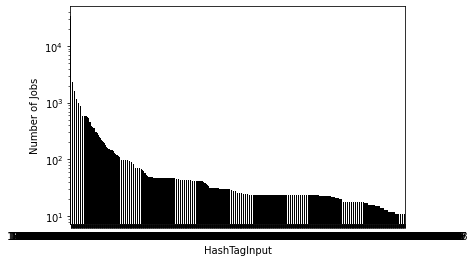

In [192]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "Number of Jobs", color="k", order=order)
plt.yscale("log")

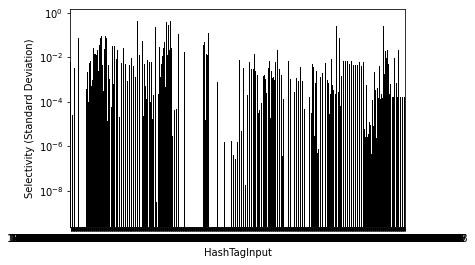

In [193]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "Selectivity (Standard Deviation)", color="k", order=order)
plt.yscale("log")

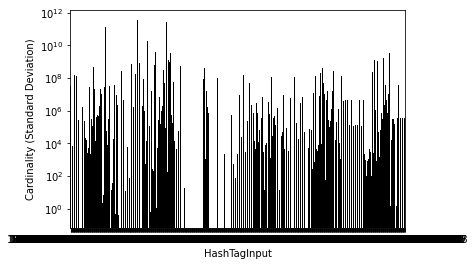

In [194]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "Cardinality (Standard Deviation)", color="k", order=order)
plt.yscale("log")

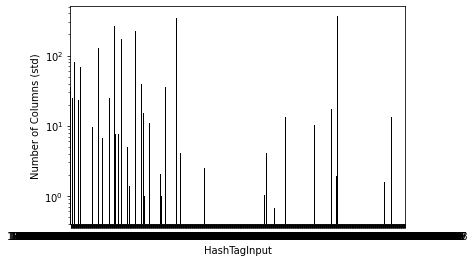

In [195]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "Number of Columns (std)", color="k", order=order)
plt.yscale("log")

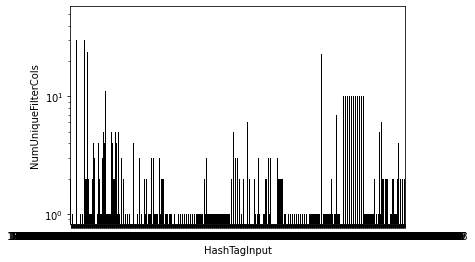

In [200]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "NumUniqueFilterCols", color="k", order=order)
plt.yscale("log")

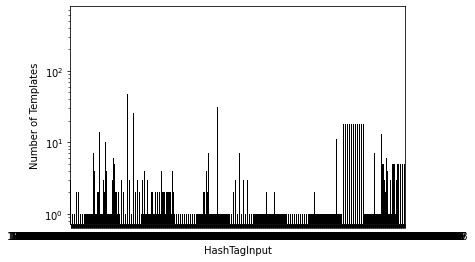

In [196]:
sns.barplot(data=inp_stats, x = INP_FIELD, y = "Number of Templates", color="k", order=order)
plt.yscale("log")

In [197]:
inp_stats["Number of Templates"].describe()

count    840.000000
mean       6.121429
std       40.146270
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      578.000000
Name: Number of Templates, dtype: float64

In [166]:
inp_stats.keys()

Index(['HashTagInput', 'Number of Jobs', 'Selectivity (Standard Deviation)',
       'Cardinality (Standard Deviation)', 'Number of Columns (std)',
       'Number of Templates', 'NumUniqueFilterCols'],
      dtype='object')

# Most filters of the kind

In [61]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df["FilterExprNorm"].values[0])

{"isComparison":true,"expOperator":"String.IsNullOrEmpty(Duration)","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":true}


In [62]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df["FilterExprNorm"].values[1])

{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"!=","attribute":{"name":"Category:3","dataType":"String"},"values":["\"Browser\""],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"AppName:2","dataType":"String"},"values":["\"Total Excludes Browser All\""],"children":[],"isSorted":true}],"isSorted":true}


In [64]:
test_attr = tmp_df["FilterExprNorm"].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

['', 'Category:3', 'AppName:2']

In [65]:
test_attr

'{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"!=","attribute":{"name":"Category:3","dataType":"String"},"values":["\\"Browser\\""],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"AppName:2","dataType":"String"},"values":["\\"Total Excludes Browser All\\""],"children":[],"isSorted":true}],"isSorted":true}'

In [316]:
len(inp_to_cols[3929217785330710594])

3

In [317]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

,HashTagInput,Number of Jobs,Selectivity (Standard Deviation),Cardinality (Standard Deviation),NumUniqueCols
1754,3929217785330710594,10,0.482537,489.229053,0


In [318]:
inp_to_cols[test["HashTagInput"].values[0]]

{'AppName:2', 'Category:3', 'ScaledEngagementMinsDisplay:9'}

In [319]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

numpy.uint64

In [321]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

<class 'int'>
3929217785330710594
3929217785330710594


# Exploring columns per input

In [67]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

join  \
                                                                        count   
HashTagInput         inputColumns                                               
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...   1.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...   2.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...   2.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...   1.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...   1.0   
...                                                                       ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...   1.0   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...   1.0   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...   1.0   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...   1.0   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...   1.0   

                                                                              \
                                                                        mean   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  0.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  0.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  0.0   
...                                                                      ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...  0.0   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...  0.0   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...  0.0   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...  0.0   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...  0.0   

                                                                              \
                                                                         std   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  NaN   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  NaN   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  NaN   
...                                                                      ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...  NaN   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...  NaN   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...  NaN   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...  NaN   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...  NaN   

                                                                              \
                                                                         min   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  0.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  0.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  0.0   
...                                                     

# How many sorted columns vs unsorted